# HW7

# Q1

We consider the Bayesian linear regression model:

$$
{y} \mid {\beta}, \sigma^2 \sim \mathcal{N}({X} {\beta}, \sigma^2 I)
$$

where the likelihood function is given by:

$$
p({y} \mid {\beta}, \sigma^2) \propto \exp \left( -\frac{1}{2 \sigma^2} ({y} - {X} {\beta})^\top ({y} - {X} {\beta}) \right)
$$

Assume the prior for ${\beta}$ is:

$$
{\beta} \sim \mathcal{N}({\beta}_0, \Sigma_{\beta})
$$

Using Bayes’ theorem, the posterior distribution of ${\beta}$ is proportional to the product of the likelihood and prior:

$$
p({\beta} \mid {y}, \sigma^2) \propto p({y} \mid {\beta}, \sigma^2) p({\beta})
$$

By completing the square, we obtain the posterior distribution:

$$
{\beta} \mid {y}, \sigma^2 \sim \mathcal{N}({\beta}_n, \Sigma_n)
$$



## Posterior Distribution of $\sigma^2$
Assume an inverse-gamma prior for $\sigma^2$:

$$
\sigma^2 \sim \text{Inv-Gamma}(\alpha^*, \beta^*)
$$

The posterior of $\sigma^2$ follows from the conjugate prior structure:

$$
p(\sigma^2 \mid {y}) \propto p({y} \mid {\beta}, \sigma^2) p(\sigma^2)
$$

After integrating out ${\beta}$, the posterior remains an inverse-gamma distribution

# Q2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

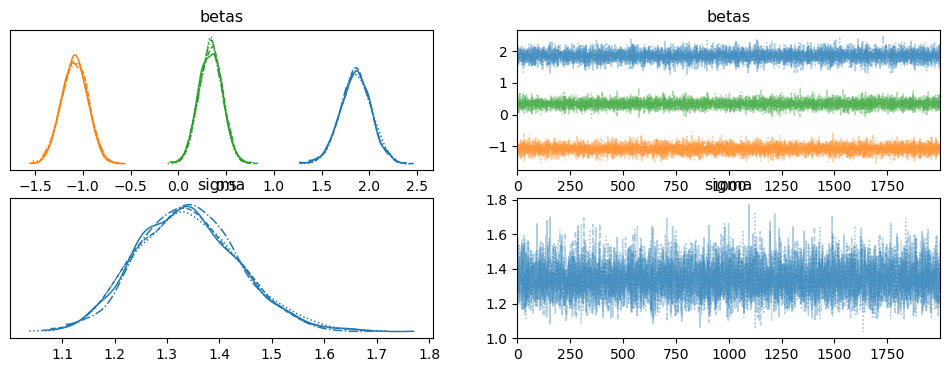

In [35]:
import pymc as pm
import numpy as np
import arviz as az

# Simulated dataset
np.random.seed(42)
n, p = 100, 3
X = np.random.randn(n, p)
true_betas = np.array([2, -1, 0.5])
y = X @ true_betas + np.random.randn(n) * 1.5  # Adding noise

# Bayesian Linear Regression Model
with pm.Model() as model:
    # Priors
    betas = pm.Normal('betas', mu=0, sigma=1, shape=p)
    sigma = pm.HalfNormal('sigma', sigma=1)  # Using HalfNormal instead of inverse-gamma
    
    # Likelihood
    y_obs = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=y)
    
    # Inference
    trace = pm.sample(2000, return_inferencedata=True, target_accept=0.95)

# Posterior analysis
az.summary(trace)
az.plot_trace(trace)


# Q3

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, tau, sigma, betas]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.


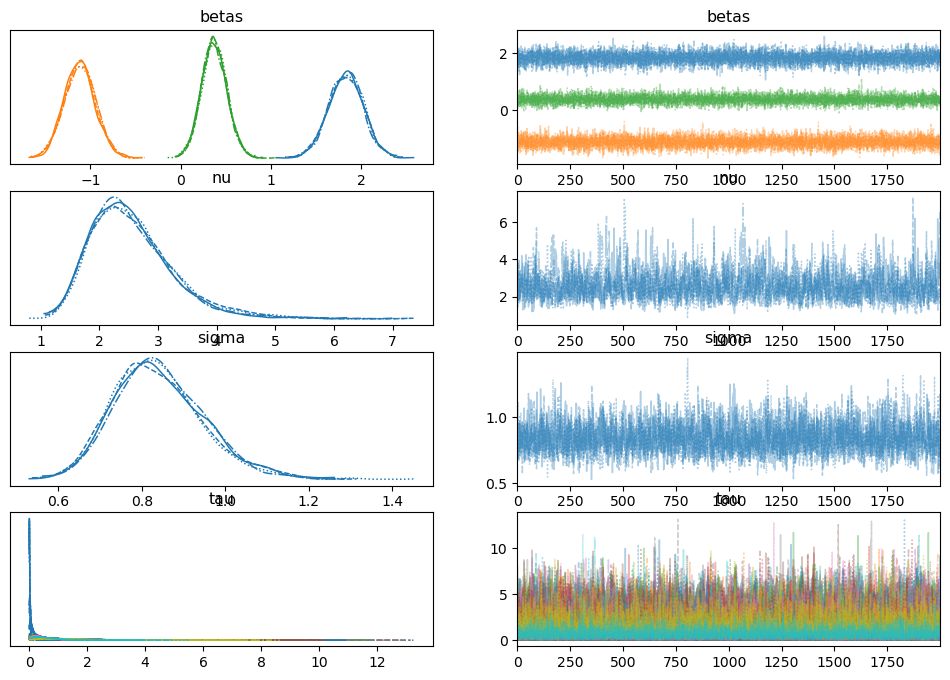

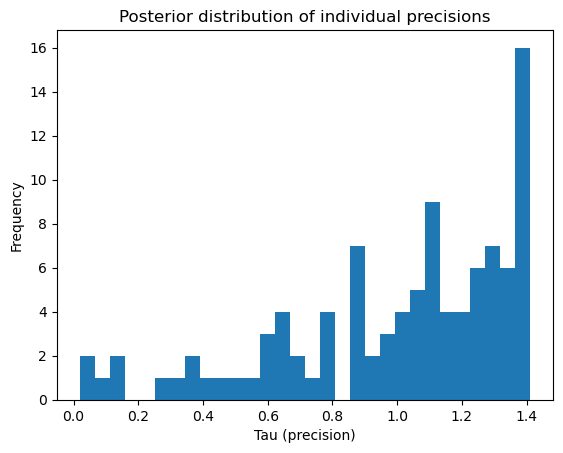

In [37]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Simulated dataset with outliers
np.random.seed(42)
n, p = 100, 3
X = np.random.randn(n, p)
true_betas = np.array([2, -1, 0.5])
y = X @ true_betas + np.random.randn(n) * 1.5  # Normal noise

# Introduce some outliers
y[::10] += np.random.randn(10) * 10

# Model specification
with pm.Model() as model:
    # Heavy-tailed prior for robustness
    nu = pm.Exponential("nu", lam=1/30)  # Prior for degrees of freedom
    tau = pm.Gamma("tau", alpha=nu/2, beta=nu/2, shape=n)  # Individual precisions
    sigma = pm.HalfNormal("sigma", sigma=1)  # Overall scale
    betas = pm.Normal("betas", mu=0, sigma=1, shape=p)
    
    # Likelihood with student-t distributed noise
    y_obs = pm.Normal("y", mu=pm.math.dot(X, betas), sigma=pm.math.sqrt(1/(tau * sigma**2)), observed=y)
    
    # Inference
    trace = pm.sample(2000, return_inferencedata=True, target_accept=0.95)

# Posterior analysis
az.summary(trace)
az.plot_trace(trace)
plt.show()

# Identifying outliers based on tau values
posterior_tau = trace.posterior["tau"].mean(dim=("chain", "draw"))
plt.hist(posterior_tau, bins=30)
plt.xlabel("Tau (precision)")
plt.ylabel("Frequency")
plt.title("Posterior distribution of individual precisions")
plt.show()

